In [1]:
# Standard library imports
import os                      # File and directory operations
from pathlib import Path        # Object-oriented filesystem paths

# Numerical & data handling
import numpy as np              # Numerical computations and arrays
import pandas as pd             # Tabular data manipulation and analysis

# Visualization libraries
import matplotlib.pyplot as plt # Core plotting library
import seaborn as sns           # Statistical data visualization (built on matplotlib)

# Image processing
from PIL import Image           # Image loading and basic processing

# Machine learning (scikit-learn)
from sklearn.model_selection import train_test_split     # Split data into train/test sets
from sklearn.preprocessing import StandardScaler         # Feature scaling (mean=0, std=1)
from sklearn.pipeline import Pipeline                    # Combine preprocessing + model
from sklearn.linear_model import LogisticRegression      # Linear classification model
from sklearn.svm import LinearSVC                        # Linear Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier      # Tree-based ensemble classifier
from sklearn.metrics import (
    classification_report,  # Precision, recall, F1-score
    confusion_matrix,        # True/false positives & negatives
    roc_auc_score,           # Area Under ROC Curve
    roc_curve                # ROC curve points
)

# Feature extraction
from skimage.feature import hog  # Histogram of Oriented Gradients (HOG) features for images

# Global visualization style
sns.set_style("whitegrid")      # Cleaner plots with grid background


In [2]:
# Root directory containing the chest X-ray dataset
DATA_DIR = Path("/Users/diyasansi/Desktop/chest_xray")

# Subdirectories for training and testing data
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

# Display paths to verify they are set correctly
TRAIN_DIR, TEST_DIR

(PosixPath('/Users/diyasansi/Desktop/chest_xray/train'),
 PosixPath('/Users/diyasansi/Desktop/chest_xray/test'))

In [3]:
def build_index(split_dir: Path):
    """
    Build a DataFrame indexing image file paths and their class labels.

    Parameters
    ----------
    split_dir : Path
        Path to a dataset split directory (e.g., train or test),
        which contains class subfolders such as 'NORMAL' and 'PNEUMONIA'.

    Returns
    -------
    pd.DataFrame
        DataFrame with two columns:
        - 'path'  : full path to each image file
        - 'label' : corresponding class label
    """
    
    rows = []  # List to collect image metadata (one dict per image)

    # Iterate over class folders
    for label_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = split_dir / label_name  # Path to the class directory

        # Iterate over all files in the class directory
        for img_path in class_dir.glob("*"):
            # Keep only valid image files
            if img_path.suffix.lower() in [".jpeg", ".jpg", ".png"]:
                rows.append({
                    "path": str(img_path),  # Convert Path to string for DataFrame compatibility
                    "label": label_name     # Store the class label
                })

    # Convert collected rows into a pandas DataFrame
    return pd.DataFrame(rows)

In [4]:
# Build indexed DataFrames for training and testing datasets
train_df = build_index(TRAIN_DIR)
test_df  = build_index(TEST_DIR)

# Print dataset sizes to verify successful loading
print("Train:", train_df.shape)
print("Test :", test_df.shape)

# Display the number of samples per class in the training set
# (useful for checking class imbalance)
train_df["label"].value_counts()

Train: (5216, 2)
Test : (624, 2)


label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

The dataset contains 5,216 training images and 624 test images, each labeled as NORMAL or PNEUMONIA. The class distribution is imbalanced, with pneumonia cases (3,875 images) occurring far more frequently than normal cases (1,341 images). While this reflects the dataset’s emphasis on disease detection, it also affects how model performance should be interpreted. In this setting, overall accuracy can be misleading, so evaluation focuses more on recall and false negatives, as missing pneumonia cases carries greater clinical risk.

In [5]:
# Compute class proportions in the training dataset
# (normalized counts sum to 1, useful for assessing class imbalance)
train_df["label"].value_counts(normalize=True)

label
PNEUMONIA    0.742906
NORMAL       0.257094
Name: proportion, dtype: float64

Approximately 74% of the training images are labeled as pneumonia, while 26% represent normal cases, confirming a strong class imbalance. In practical terms, this means a model could appear to perform well by favoring the majority class without truly learning clinically meaningful patterns. For this reason, evaluation emphasizes recall, false negatives, and confusion matrices rather than accuracy alone, as missed pneumonia cases carry more serious consequences in a healthcare setting.

In [6]:
def show_samples(df, title, n=6):
    """
    Display a grid of random sample images from a dataset.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least 'path' and 'label' columns.
    title : str
        Title displayed above the entire figure.
    n : int, optional
        Number of images to display (default is 6).
    """
    
    # Randomly sample n rows for reproducibility
    sample = df.sample(n, random_state=42)

    # Create a figure large enough to display multiple images clearly
    plt.figure(figsize=(12, 6))

    # Loop through sampled images and plot them
    for i, (_, row) in enumerate(sample.iterrows(), 1):
        # Load image and convert to grayscale
        img = Image.open(row["path"]).convert("L")

        # Create subplot (2 rows x 3 columns)
        plt.subplot(2, 3, i)
        plt.imshow(img, cmap="gray")
        plt.title(row["label"])  # Display class label as title
        plt.axis("off")          # Hide axes for cleaner visualization

    # Add a title for the entire figure
    plt.suptitle(title)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Render the figure
    plt.show()

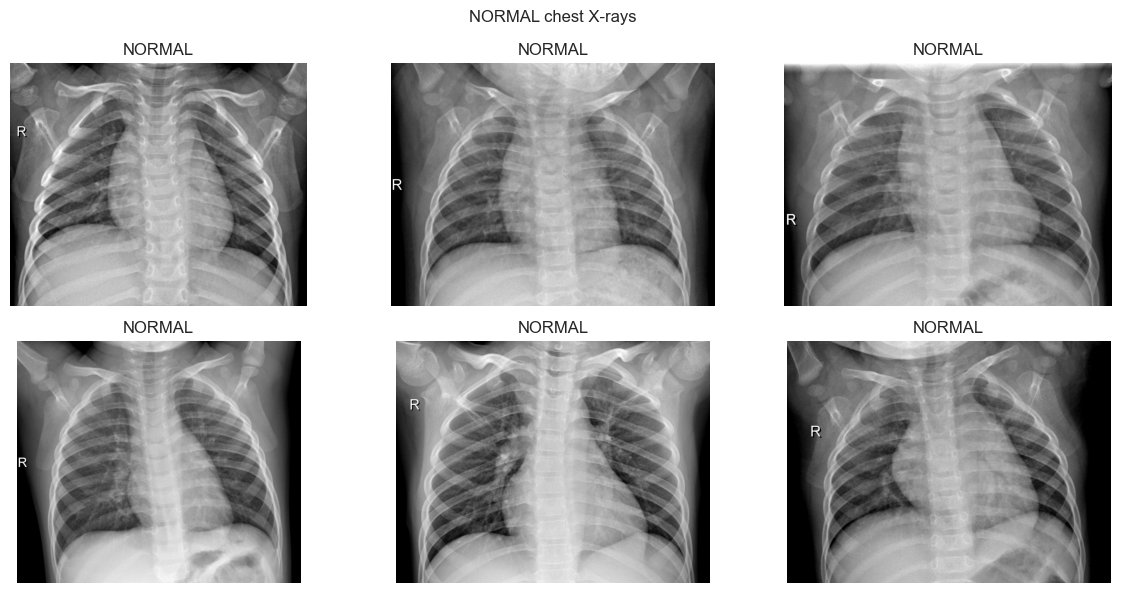

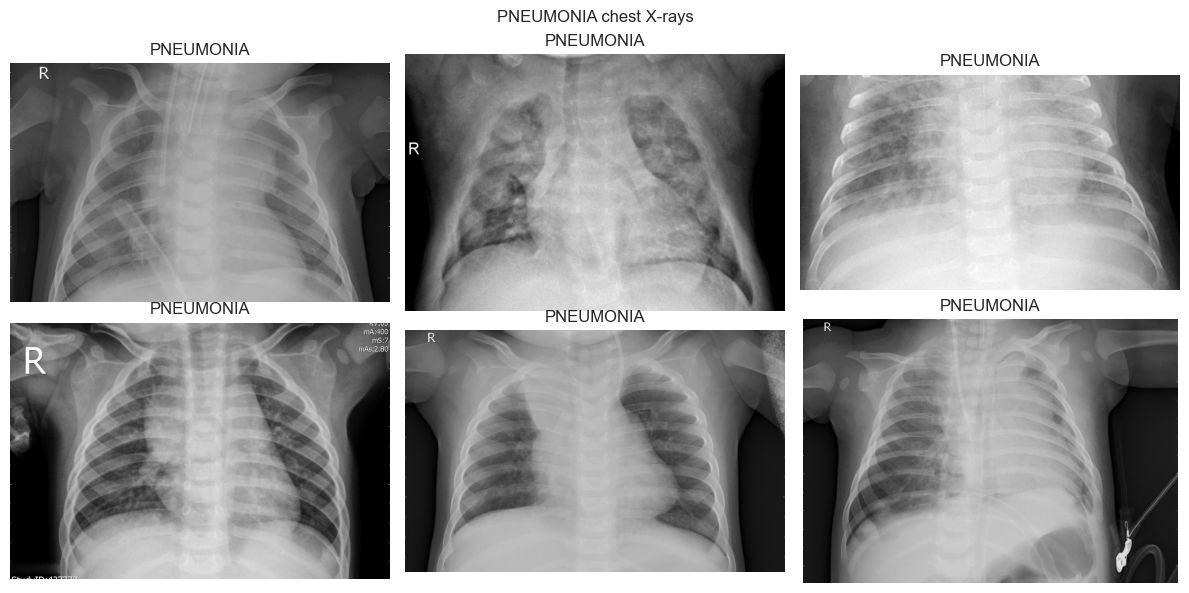

In [7]:
# Visualize random samples of NORMAL chest X-ray images
show_samples(
    train_df[train_df["label"] == "NORMAL"],
    "NORMAL chest X-rays"
)

# Visualize random samples of PNEUMONIA chest X-ray images
show_samples(
    train_df[train_df["label"] == "PNEUMONIA"],
    "PNEUMONIA chest X-rays"
)

Visual inspection of the sample images helps clarify what the model is learning. Normal chest X-rays generally show clear lung fields with uniform shading, whereas pneumonia X-rays often contain cloudy or opaque regions caused by fluid or inflammation. Although these differences can be subtle—especially to non-experts—machine learning models can identify consistent pixel-level patterns when trained across large numbers of images.

In [8]:
# Target image size for all inputs (width, height)
IMG_SIZE = (128, 128)

def load_image_gray(path, size=IMG_SIZE):
    """
    Load an image, convert it to grayscale, resize it, and normalize pixel values.

    Parameters
    ----------
    path : str or Path
        File path to the image.
    size : tuple, optional
        Target image size as (width, height). Default is IMG_SIZE.

    Returns
    -------
    np.ndarray
        2D numpy array of shape (height, width) with pixel values
        normalized to the range [0, 1].
    """
    
    # Open image and convert to grayscale (single channel)
    img = Image.open(path).convert("L")

    # Resize image to a fixed size for model compatibility
    img = img.resize(size)

    # Convert image to NumPy array and normalize pixel values
    arr = np.array(img, dtype=np.float32) / 255.0

    return arr

In [9]:
def pixel_stats(df, n=200):
    """
    Compute mean pixel intensity statistics for a random subset of images.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image file paths in a 'path' column.
    n : int, optional
        Number of images to sample for statistics (default is 200).

    Returns
    -------
    np.ndarray
        Array of mean pixel values (one per sampled image).
    """
    
    means = []  # Store mean pixel intensities for each sampled image

    # Randomly sample image paths for reproducibility
    for p in df.sample(n, random_state=42)["path"]:
        # Load preprocessed grayscale image
        img = load_image_gray(p)

        # Compute and store mean pixel intensity
        means.append(img.mean())

    # Convert list to NumPy array for downstream analysis
    return np.array(means)

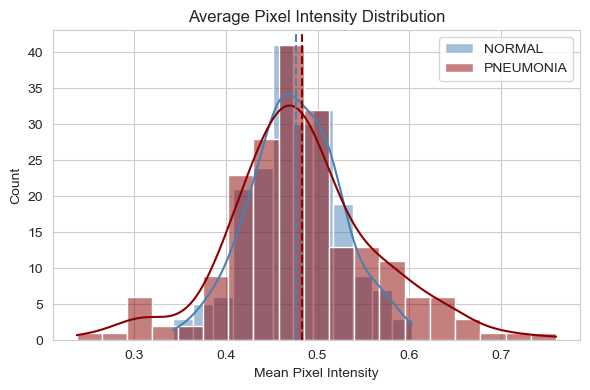

In [11]:
# Compute mean pixel intensities for each class
normal_means = pixel_stats(train_df[train_df["label"] == "NORMAL"])
pneumonia_means = pixel_stats(train_df[train_df["label"] == "PNEUMONIA"])

# Create histogram to compare intensity distributions
plt.figure(figsize=(6, 4))

# Plot distribution for NORMAL images
sns.histplot(
    normal_means,
    color="steelblue",
    label="NORMAL",
    kde=True
)

# Plot distribution for PNEUMONIA images
sns.histplot(
    pneumonia_means,
    color="darkred",
    label="PNEUMONIA",
    kde=True
)

# Add titles and labels
plt.title("Average Pixel Intensity Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.legend()

# Annotate the mean lines
plt.axvline(normal_means.mean(), linestyle="--", color="steelblue")
plt.axvline(pneumonia_means.mean(), linestyle="--", color="darkred")

# Improve layout and display plot
plt.tight_layout()
plt.show()


This plot compares the distribution of average pixel intensity between normal and pneumonia chest X-rays, where each image is summarized by its overall brightness. Pneumonia images tend to show slightly higher average intensities and greater variability than normal images. This is consistent with clinical expectations, as fluid or inflammation in the lungs often appears brighter on X-rays. Although the two distributions overlap, the observed difference indicates that pixel intensity contains useful information and can contribute to classification when combined with more detailed image features.

In [12]:
# Load a single image to verify preprocessing output
test_arr = load_image_gray(train_df.iloc[0]["path"])

# Inspect shape and value range:
# - shape should match IMG_SIZE
# - min/max should be within [0, 1] after normalization
test_arr.shape, test_arr.min(), test_arr.max()

((128, 128), np.float32(0.0), np.float32(0.92156863))

This output describes a chest X-ray after preprocessing. The image is resized to 128 × 128 pixels, ensuring that all images share the same dimensions for consistent model input. Pixel values are stored as 32-bit floating point numbers and normalized to a 0–1 range, where 0 represents black and higher values represent brighter regions. This normalization stabilizes model training and ensures that brightness differences are comparable across images.

In [13]:
def hog_features(img_arr):
    """
    Extract Histogram of Oriented Gradients (HOG) features from an image.

    Parameters
    ----------
    img_arr : np.ndarray
        Grayscale image array (2D) with values normalized to [0, 1].

    Returns
    -------
    np.ndarray
        1D array of HOG feature descriptors.
    """
    
    # Compute HOG features
    feats = hog(
        img_arr,
        orientations=9,            # Number of gradient orientation bins
        pixels_per_cell=(8, 8),    # Size of each cell in pixels
        cells_per_block=(2, 2),    # Number of cells per block
        block_norm="L2-Hys"        # Block normalization method (robust to illumination changes)
    )

    return feats

In [14]:
# Extract HOG features from a sample image
f = hog_features(test_arr)

# Check the dimensionality of the HOG feature vector
len(f)

8100

This output shows that each chest X-ray image is represented by 8,100 HOG (Histogram of Oriented Gradients) features. Rather than relying on raw pixel values, HOG captures edge orientation, shape, and texture patterns, which are particularly important for identifying structural changes in the lungs. Representing each image as a fixed-length numerical vector allows traditional machine learning models, such as logistic regression and SVMs, to process the data effectively, bridging the gap between medical images and tabular machine learning methods.

In [15]:
def make_X_y(df):
    """
    Convert a DataFrame of image paths and labels into feature matrix X and label vector y.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing:
        - 'path'  : file paths to images
        - 'label' : class labels ('NORMAL' or 'PNEUMONIA')

    Returns
    -------
    X : np.ndarray
        2D feature matrix of shape (n_samples, n_features),
        where each row contains HOG features for one image.
    y : np.ndarray
        1D label array of shape (n_samples,),
        where 1 = PNEUMONIA and 0 = NORMAL.
    """
    
    X_list = []  # Will hold HOG feature vectors
    y_list = []  # Will hold encoded class labels

    # Iterate over image paths and labels together
    for p, lbl in zip(df["path"], df["label"]):
        # Load and preprocess image
        img_arr = load_image_gray(p)

        # Extract HOG features
        feats = hog_features(img_arr)

        # Append features to feature list
        X_list.append(feats)

        # Encode labels: PNEUMONIA -> 1, NORMAL -> 0
        y_list.append(1 if lbl == "PNEUMONIA" else 0)

    # Stack feature vectors into a single 2D array
    X = np.vstack(X_list)

    # Convert label list to NumPy array
    y = np.array(y_list)

    return X, y

In [16]:
# Generate feature matrices and label vectors for training and testing sets
X_train, y_train = make_X_y(train_df)
X_test, y_test   = make_X_y(test_df)

# Verify the shapes of the resulting feature matrices
# (number of samples, number of HOG features)
X_train.shape, X_test.shape

((5216, 8100), (624, 8100))

This output shows the final shape of the feature matrices used for model training and evaluation. The training set includes 5,216 images and the test set includes 624 images, with each image represented by 8,100 numerical features derived from the HOG extraction process. As a result, all chest X-rays are converted into a standardized format that captures structural patterns consistently, allowing the models to learn from the training data and apply the same representations during evaluation.

In [17]:
# Directory to store extracted features and labels
FEATURE_DIR = Path("features")

# Create the directory if it does not already exist
FEATURE_DIR.mkdir(exist_ok=True)

# Save feature matrices and label vectors as NumPy binary files
# (fast to load and memory-efficient)
np.save(FEATURE_DIR / "X_train.npy", X_train)
np.save(FEATURE_DIR / "y_train.npy", y_train)
np.save(FEATURE_DIR / "X_test.npy", X_test)
np.save(FEATURE_DIR / "y_test.npy", y_test)

# Confirm where the features were saved
print("Saved features to:", FEATURE_DIR.resolve())

Saved features to: /Users/diyasansi/features


To improve efficiency and reproducibility, the extracted features and labels were saved to disk as NumPy arrays. This allows model training and evaluation to be repeated without rerunning the computationally expensive image preprocessing steps. Reloading these files enables faster experimentation while ensuring consistent results, and also makes the project easier to share and reproduce without requiring access to the full image processing pipeline.

to reload:

X_train = np.load("features/X_train.npy")

y_train = np.load("features/y_train.npy")

X_test  = np.load("features/X_test.npy")

y_test  = np.load("features/y_test.npy")

We compare three strong baselines for HOG-based image classification:
(1) Logistic Regression: fast, interpretable linear baseline

(2) Linear SVM: often strong on high-dimensional HOG features

(3) Random Forest: non-linear ensemble to capture feature interactions

Class weights are balanced to reduce bias from class imbalance.

In [18]:
# Dictionary of models to evaluate
models = {
    # -------------------------
    # Logistic Regression model
    # -------------------------
    "Logistic Regression": Pipeline([
        # Standardize features (important for linear models)
        ("scaler", StandardScaler()),
        
        # Linear classifier with class balancing
        ("clf", LogisticRegression(
            max_iter=2000,          # Increase iterations to ensure convergence
            class_weight="balanced" # Handle class imbalance
        ))
    ]),

    # -------------------------
    # Linear Support Vector Machine
    # -------------------------
    "Linear SVM": Pipeline([
        # Feature scaling is critical for SVMs
        ("scaler", StandardScaler()),
        
        # Linear SVM classifier with balanced class weights
        ("clf", LinearSVC(
            class_weight="balanced",
            max_iter=10000          # Higher iteration limit for convergence
        ))
    ]),

    # -------------------------
    # Random Forest model
    # -------------------------
    "Random Forest": RandomForestClassifier(
        n_estimators=200,          # Number of trees in the forest
        max_depth=None,            # Allow trees to grow fully
        class_weight="balanced",   # Address class imbalance
        random_state=42,           # Reproducibility
        n_jobs=-1                  # Use all available CPU cores
    )
}

In [19]:
# List to store summary metrics for each model
results = []

# Train and evaluate each model
for name, model in models.items():
    print("=" * 60)
    print(name)

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict labels on the test set
    y_pred = model.predict(X_test)

    # Print detailed classification metrics
    # (precision, recall, F1-score for each class)
    print(classification_report(
        y_test,
        y_pred,
        target_names=["NORMAL", "PNEUMONIA"]
    ))

    # Compute confusion matrix to analyze error types
    cm = confusion_matrix(y_test, y_pred)

    # Store key metrics for later comparison
    results.append({
        "model": name,
        "accuracy": (y_pred == y_test).mean(),  # Overall correctness
        "false_negatives": cm[1, 0],             # PNEUMONIA predicted as NORMAL (critical error)
        "false_positives": cm[0, 1]              # NORMAL predicted as PNEUMONIA
    })

Logistic Regression
              precision    recall  f1-score   support

      NORMAL       0.94      0.44      0.60       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624

Linear SVM
              precision    recall  f1-score   support

      NORMAL       0.88      0.51      0.65       234
   PNEUMONIA       0.77      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.74      0.75       624
weighted avg       0.81      0.79      0.78       624

Random Forest
              precision    recall  f1-score   support

      NORMAL       0.95      0.32      0.48       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      

# Logistic Regression Results

The logistic regression model is highly sensitive to pneumonia, achieving a recall of 0.98, meaning it correctly identifies nearly all pneumonia cases. However, it performs poorly on normal images, with a recall of 0.44, resulting in many healthy cases being misclassified as pneumonia. Although the overall accuracy is 78%, this metric masks the imbalance between the two classes. In practice, this model behaves as a conservative screening tool, favoring disease detection while generating a relatively high number of false positives.

# Linear SVM Results

The Linear SVM achieves the highest overall accuracy (79%) and offers the most balanced performance across classes. It maintains strong pneumonia recall (0.96) while improving normal-case recall to 0.51, reducing false positives compared to logistic regression. This indicates that the SVM learns a more refined decision boundary, making it a good compromise between sensitivity to pneumonia and correct identification of normal cases.

# Random Forest Results

The Random Forest model places the strongest emphasis on detecting pneumonia, achieving the highest pneumonia recall (0.99) and the fewest missed cases. However, this comes at the expense of normal-case classification, with a recall of only 0.32, leading to many false positives. Despite a lower overall accuracy (74%), this model minimizes the most clinically dangerous error—missing a pneumonia diagnosis—which can be critical in a screening context.

# Overall Model Comparison

All three models demonstrate useful performance but differ in how they balance errors. The Linear SVM provides the best overall balance between accuracy and class-level performance. The Random Forest, while less accurate overall, is the safest option for screening because it minimizes missed pneumonia cases. These results reinforce that accuracy alone is insufficient in healthcare applications and that model selection must consider the clinical cost of different error types.

In [20]:
# Convert collected model results into a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Sort models by number of false negatives (ascending)
# Fewer false negatives is especially important in medical diagnosis
results_df.sort_values("false_negatives")

,model,accuracy,false_negatives,false_positives
2,Random Forest,0.740385,4,158
0,Logistic Regression,0.778846,7,131
1,Linear SVM,0.791667,16,114


This table compares the three models using overall accuracy and two critical error types: false negatives (missed pneumonia cases) and false positives (normal cases incorrectly flagged as pneumonia). While the Linear SVM achieves the highest accuracy, it also produces the largest number of false negatives, which represents the most serious risk in a healthcare setting. In contrast, the Random Forest model has lower overall accuracy but misses the fewest pneumonia cases, failing to identify only four cases in the test set. Logistic regression falls between these two models in both accuracy and error rates. These results highlight that model selection should be guided not only by accuracy, but by the clinical impact of different errors, making the Random Forest model the safest choice for pneumonia screening.

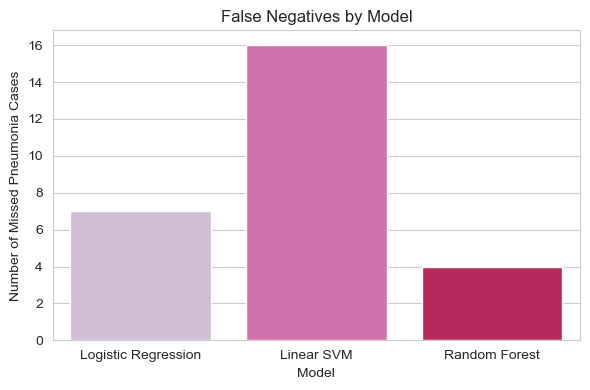

In [21]:
# Visualize the number of false negatives for each model
plt.figure(figsize=(6, 4))

sns.barplot(
    data=results_df,
    x="model",
    y="false_negatives",
    hue="model",          # Color bars by model for clarity
    palette="PuRd"        # Red-toned palette to emphasize risk
)

# Add informative titles and labels
plt.title("False Negatives by Model")
plt.ylabel("Number of Missed Pneumonia Cases")
plt.xlabel("Model")

# Improve spacing and readability
plt.tight_layout()

# Display the plot
plt.show()

This chart shows how often each model fails to detect pneumonia, measured by the number of false negatives. In a screening setting, false negatives are especially concerning because they represent patients who are incorrectly classified as healthy. The Linear SVM produces the highest number of missed cases, while logistic regression performs somewhat better. The Random Forest model stands out by missing the fewest pneumonia cases, making it the most conservative and safest option when minimising missed diagnoses is the primary goal. This visualization reinforces the importance of evaluating models based on clinically meaningful errors rather than accuracy alone.

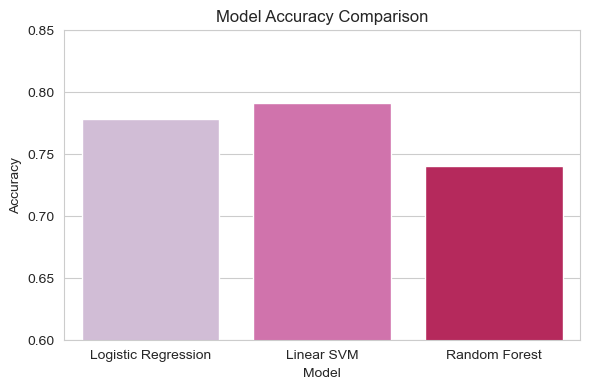

In [22]:
# Visualize overall accuracy for each model
plt.figure(figsize=(6, 4))

sns.barplot(
    data=results_df,
    x="model",
    y="accuracy",
    hue="model",          # Color bars by model
    palette="PuRd"        # Consistent color scheme with previous plots
)

# Add titles and axis labels
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")

# Set y-axis limits to focus on relevant accuracy range
plt.ylim(0.6, 0.85)

# Improve layout and display plot
plt.tight_layout()
plt.show()

This chart compares the overall accuracy of the three models: Logistic Regression, Linear SVM, and Random Forest. Accuracy reflects the proportion of chest X-rays correctly classified as either NORMAL or PNEUMONIA. The Linear SVM achieves the highest accuracy, followed closely by Logistic Regression, while the Random Forest performs slightly worse overall. However, this comparison also illustrates a key limitation of accuracy as a standalone metric. As shown in earlier analyses, models with similar accuracy can differ substantially in the types of errors they make, and a model with lower accuracy may still be preferable in a medical setting if it reduces missed pneumonia cases.

In [23]:
# Logistic Regression probabilities

# Retrieve the trained Logistic Regression pipeline
logreg_model = models["Logistic Regression"]

# Predict class probabilities for the test set
# We take the probability of the positive class (PNEUMONIA = 1)
logreg_probs = logreg_model.predict_proba(X_test)[:, 1]


# Random Forest probabilities

# Retrieve the trained Random Forest model
rf_model = models["Random Forest"]

# Predict class probabilities for the test set
# Again, select probabilities for the PNEUMONIA class
rf_probs = rf_model.predict_proba(X_test)[:, 1]

In [24]:
# Compute ROC curve points for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(
    y_test,
    logreg_probs
)

# Compute ROC curve points for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(
    y_test,
    rf_probs
)

# Calculate Area Under the ROC Curve (AUC)
# AUC summarizes the model's ability to separate classes across all thresholds
auc_log = roc_auc_score(y_test, logreg_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

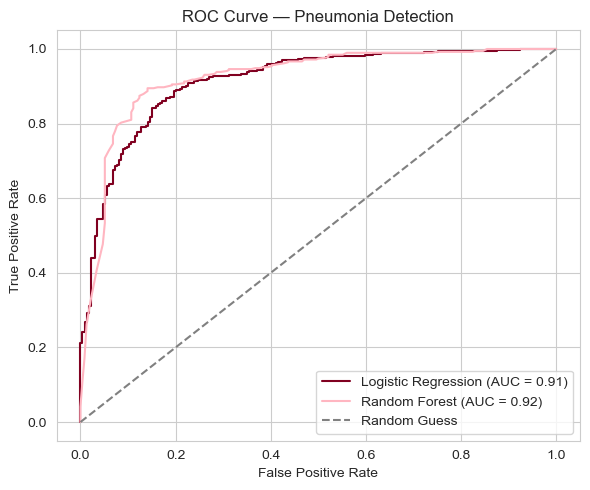

In [27]:
# Plot ROC curves to compare model discrimination performance
plt.figure(figsize=(6, 5))

# ROC curve for Logistic Regression
plt.plot(
    fpr_log,
    tpr_log,
    label=f"Logistic Regression (AUC = {auc_log:.2f})",
    color="#800020"
)

# ROC curve for Random Forest
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f"Random Forest (AUC = {auc_rf:.2f})",
    color="#ffb6c1"
)

# Reference line representing random guessing (AUC = 0.5)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="gray",
    label="Random Guess"
)

# Axis labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Pneumonia Detection")

# Display legend and finalize layout
plt.legend()
plt.tight_layout()
plt.show()

This ROC curve illustrates how well each model separates NORMAL and PNEUMONIA chest X-rays across different classification thresholds. The x-axis shows the false positive rate, while the y-axis represents the true positive rate. The dashed diagonal line indicates random guessing, and curves well above this line reflect meaningful predictive performance.

Both Logistic Regression and Random Forest perform clearly above the random baseline, demonstrating a strong ability to distinguish between the two classes. The Random Forest achieves a slightly higher AUC (0.92) than Logistic Regression (0.91), indicating a marginal advantage in overall discrimination. However, the curves are very similar, suggesting that both models learn comparable patterns from the data. In a medical setting, this highlights that AUC should be considered alongside clinically important errors—especially false negatives, where pneumonia cases are missed.

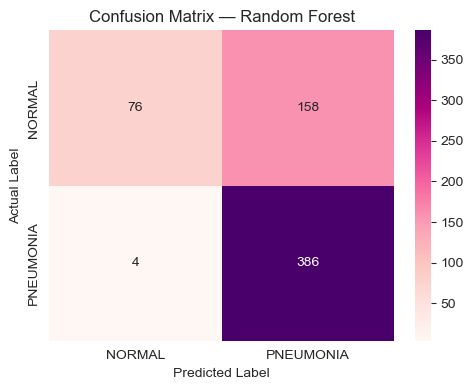

In [28]:
# Final model selection

# Select the best-performing model based on minimizing false negatives
# (missing pneumonia cases is the most critical error)
best_model = models["Random Forest"]

# Generate predictions on the test set using the selected model
y_pred = best_model.predict(X_test)

# Confusion matrix analysis

# Compute confusion matrix to analyze prediction errors
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,                 # Display counts in each cell
    fmt="d",
    cmap="RdPu",                # Red-toned colormap to emphasize risk
    xticklabels=["NORMAL", "PNEUMONIA"],
    yticklabels=["NORMAL", "PNEUMONIA"]
)

# Add titles and axis labels
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

# Improve layout and display plot
plt.tight_layout()
plt.show()

This confusion matrix shows how the Random Forest model classifies chest X-rays as NORMAL or PNEUMONIA, with each cell representing a specific prediction outcome. The model correctly identifies 386 pneumonia cases, reflecting its very high sensitivity. Only four pneumonia cases are missed, indicating that the model rarely classifies a sick patient as healthy.

At the same time, the model incorrectly labels 158 normal X-rays as pneumonia, resulting in a relatively high false positive rate. In a screening context, this behavior may be acceptable or even desirable, as prioritising sensitivity reduces the risk of missed diagnoses. However, the increased number of false positives could lead to additional follow-up tests, higher clinical workload, and potential patient anxiety. This trade-off highlights the balance between sensitivity and specificity and underscores why model evaluation must extend beyond accuracy alone.

**Final Conclusions**

This project examined how machine learning models can assist in classifying chest X-rays as NORMAL or PNEUMONIA using image-based features. While the task may seem straightforward, the results demonstrate the complexity and risk involved in medical classification problems, where different types of errors carry very different consequences.

Across all models, pneumonia cases were generally easier to identify than normal cases, partly due to the dataset being heavily weighted toward pneumonia images. The Linear SVM achieved the highest overall accuracy, but it also produced the most false negatives, meaning it missed more pneumonia cases. In a healthcare setting, this is a critical limitation, as missed diagnoses can delay treatment and negatively affect patient outcomes.

The Random Forest model showed a different error profile. Although its overall accuracy was slightly lower, it missed very few pneumonia cases and achieved the highest sensitivity. This came at the cost of more false positives, meaning more healthy patients were flagged for further evaluation. In many screening scenarios, this trade-off is acceptable, as it is safer to investigate a healthy patient further than to overlook a serious condition.

Logistic Regression provided a middle-ground solution, with balanced performance across accuracy, recall, and error types. Its interpretability is also an advantage in medical contexts, where understanding and explaining model behavior is often important.

Overall, this analysis shows that there is no single “best” model in isolation. The most appropriate model depends on how different errors affect real-world outcomes. In medical applications, evaluation must go beyond accuracy and focus on clinical risk, especially the cost of missed diagnoses.

By combining image feature extraction, multiple machine learning models, and clinically informed evaluation, this project highlights both the promise and the limitations of machine learning as a decision-support tool. These models are best used to support—not replace—clinical judgment, helping clinicians identify cases that may require closer attention.

**Clinical Takeaway**

When applying machine learning to medical imaging, minimizing missed diagnoses should take priority over maximizing overall accuracy. In this study, models with slightly lower accuracy but fewer false negatives may be better suited for pneumonia screening, where failing to detect a positive case carries greater clinical risk than a false alarm. These findings emphasize the importance of aligning model evaluation with real-world healthcare priorities rather than relying on accuracy alone.

In [29]:
# =========================
# Core numerical computing
# =========================
import numpy as np                      # Array operations and numerical computations

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt         # Plotting and visualization

# =========================
# Image processing (scikit-image)
# =========================
from skimage.io import imread            # Load images from disk
from skimage.color import rgb2gray       # Convert RGB images to grayscale
from skimage.transform import resize    # Resize images to a fixed shape
from skimage.feature import hog          # Extract Histogram of Oriented Gradients (HOG) features

In [30]:
# Assign the selected best-performing model to a generic variable
# for easier reuse in prediction or deployment steps
model = best_model

In [31]:
def preprocess_single_image(
    image_path,
    img_size=(128, 128)
):
    """
    Load and preprocess a single image for model inference.

    This function mirrors the training preprocessing steps:
    grayscale conversion, resizing, and HOG feature extraction.

    Parameters
    ----------
    image_path : str
        Path to the input image file.
    img_size : tuple, optional
        Target image size (width, height). Default is (128, 128).

    Returns
    -------
    img : np.ndarray
        Preprocessed grayscale image resized to img_size.
    features : np.ndarray
        1D HOG feature vector extracted from the image.
    """
    
    # Load image from disk
    img = imread(image_path)
    
    # Convert to grayscale if the image has multiple color channels
    if img.ndim == 3:
        img = rgb2gray(img)
    
    # Resize image to match training dimensions
    img = resize(img, img_size, anti_aliasing=True)
    
    # Extract HOG features using the same parameters as during training
    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )
    
    return img, features

In [32]:
# File paths to sample images for model inference/testing
IMAGE_PATH_1 = "/Users/diyasansi/Desktop/test_1.jpg"
IMAGE_PATH_2 = "/Users/diyasansi/Desktop/test_2.jpg"

In [33]:
# Preprocess a single input image and extract HOG features
img, features = preprocess_single_image(IMAGE_PATH_1)

# Reshape feature vector to match model input shape (1 sample, n_features)
X_single = features.reshape(1, -1)

# Generate class prediction for the image
prediction = model.predict(X_single)[0]

# Obtain predicted class probabilities
# proba[0] -> probability of NORMAL
# proba[1] -> probability of PNEUMONIA
proba = model.predict_proba(X_single)[0]

In [34]:
# Map numeric model outputs back to human-readable class labels
labels = {
    0: "NORMAL",
    1: "PNEUMONIA"
}

# Convert numeric prediction to label
predicted_label = labels[prediction]

# Extract model confidence for the predicted class
confidence = proba[prediction]

# Display prediction results
print(f"Model prediction: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

Model prediction: PNEUMONIA
Confidence: 63.50%


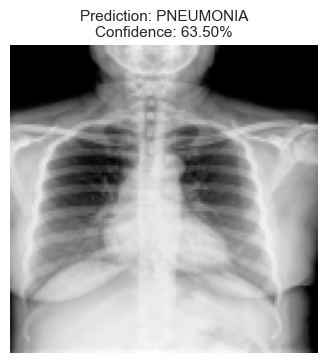

In [35]:
# Display the input image along with the model's prediction and confidence
plt.figure(figsize=(4, 4))

# Show the preprocessed grayscale image
plt.imshow(img, cmap="gray")
plt.axis("off")  # Hide axes for a cleaner display

# Add prediction result and confidence as the title
plt.title(
    f"Prediction: {predicted_label}\nConfidence: {confidence:.2%}",
    fontsize=11
)

# Render the figure
plt.show()

In [36]:
# Preprocess the second input image and extract HOG features
img, features = preprocess_single_image(IMAGE_PATH_2)

# Reshape features to match model input format (1 sample, n_features)
X_single = features.reshape(1, -1)

# Generate class prediction for the image
prediction = model.predict(X_single)[0]

# Obtain predicted class probabilities
proba = model.predict_proba(X_single)[0]

In [37]:
# Map numeric class predictions to human-readable labels
labels = {
    0: "NORMAL",
    1: "PNEUMONIA"
}

# Decode model prediction
predicted_label = labels[prediction]

# Extract confidence score for the predicted class
confidence = proba[prediction]

# Print prediction results
print(f"Model prediction: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

Model prediction: PNEUMONIA
Confidence: 69.50%


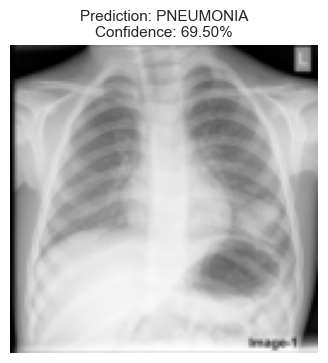

In [38]:
# Display the second input image with the model's prediction and confidence
plt.figure(figsize=(4, 4))

# Show the preprocessed grayscale image
plt.imshow(img, cmap="gray")
plt.axis("off")  # Hide axes for clarity

# Add prediction label and confidence to the title
plt.title(
    f"Prediction: {predicted_label}\nConfidence: {confidence:.2%}",
    fontsize=11
)

# Render the figure
plt.show()

**Interpretation**

This output shows the model’s prediction for a single chest X-ray image along with a confidence score. The confidence value indicates how strongly the model associates the image’s visual features with the predicted class based on patterns learned during training.

While this example demonstrates the potential of machine learning to support medical image analysis, it also highlights its limitations. Model predictions should be interpreted cautiously and always considered alongside expert clinical judgment, rather than used as standalone diagnostic decisions.